In [1]:
# Dependencies set up
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# Create engine using hawaii.sqlite database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Take a peak at what the the measurement table look
inspector = inspect(engine)
m_columns = inspector.get_columns('measurement')

for column in m_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Take a peak at what the the station table look
s_columns = inspector.get_columns('station')

for column in s_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
firstdate = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
rain_data = session.query(Measurement.date, Measurement.prcp).\
            filter(func.strftime(Measurement.date) >= firstdate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(rain_data)

prcp_df = prcp_df.rename(columns={'date': 'Date', 'prcp': 'precipitation'})

prcp_df.set_index('Date', inplace=True)


# Sort the dataframe by date - Already sorted... 
prcp_df = prcp_df.sort_values('Date', ascending=False)
prcp_df = prcp_df.dropna(how='any')

<Figure size 576x432 with 0 Axes>

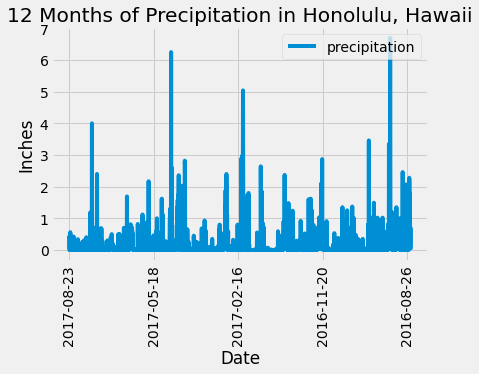

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(8,6))
prcp_df.plot(rot=90, fontsize=14)
plt.title('12 Months of Precipitation in Honolulu, Hawaii')
plt.ylabel('Inches')
plt.legend(loc='upper right')
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_mean = prcp_df['precipitation'].mean()

prcp_median = prcp_df['precipitation'].median()

prcp_var = prcp_df['precipitation'].var()

prcp_sd = prcp_df['precipitation'].std()

prcp_sem = prcp_df['precipitation'].sem()

summary_statistic = pd.DataFrame({'Mean':[prcp_mean],
                                 'Median': prcp_median,
                                 'Variance': prcp_var,
                                 'Standard Deviation': prcp_sd,
                                 'SEM': prcp_sem},
                                index=['Precipitation'],
                                columns=('Mean', 'Median', 'Variance',
                                       'Standard Deviation','SEM'))
summary_statistic

,Mean,Median,Variance,Standard Deviation,SEM
Precipitation,0.177279,0.02,0.212696,0.46119,0.010259


In [15]:
# Design a query to show how many stations are available in this dataset?
station = session.query(Measurement.station).\
group_by(Measurement.station).count()

# OR
station = session.query(Station.id, Station.station).count()

station

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
query = [Station.id, Measurement.station, func.count(Measurement.station)]

most_active_station = session.query(*query).\
filter(Station.station == Measurement.station).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).first()

print(f'The most active station: #{most_active_station[0]} {most_active_station[1]} with {most_active_station[2]} data.')

# List the stations and the counts in descending order.
station_detail = session.query(*query).\
filter(Station.station == Measurement.station).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

station_detail

The most active station: #7 USC00519281 with 2772 data.


[(7, 'USC00519281', 2772),
 (1, 'USC00519397', 2724),
 (2, 'USC00513117', 2709),
 (6, 'USC00519523', 2669),
 (9, 'USC00516128', 2612),
 (3, 'USC00514830', 2202),
 (8, 'USC00511918', 1979),
 (4, 'USC00517948', 1372),
 (5, 'USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

tobs7 = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Station.id == most_active_station[0]).\
filter(Station.station == Measurement.station).all()

for tob in tobs7:
    print(f'At {most_active_station[1]}:')
    print(f'Lowest temperature recorded: {tob[0]}')
    print(f'Highest temperature recorded: {tob[1]}')
    print(f'Average temperature: {tob[2]}')
    

At USC00519281:
Lowest temperature recorded: 54.0
Highest temperature recorded: 85.0
Average temperature: 71.66378066378067


In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_station = session.query(Measurement.tobs).\
filter(Station.id == most_active_station[0]).\
filter(Station.station == Measurement.station).\
filter(func.strftime(Measurement.date) >= firstdate).\
order_by(Measurement.date).all()

highest_station

[(77.0),
 (77.0),
 (80.0),
 (80.0),
 (75.0),
 (73.0),
 (78.0),
 (77.0),
 (78.0),
 (80.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (73.0),
 (74.0),
 (80.0),
 (79.0),
 (77.0),
 (80.0),
 (76.0),
 (79.0),
 (75.0),
 (79.0),
 (78.0),
 (79.0),
 (78.0),
 (78.0),
 (76.0),
 (74.0),
 (77.0),
 (78.0),
 (79.0),
 (79.0),
 (77.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (75.0),
 (76.0),
 (73.0),
 (72.0),
 (71.0),
 (77.0),
 (79.0),
 (78.0),
 (79.0),
 (77.0),
 (79.0),
 (77.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (74.0),
 (75.0),
 (76.0),
 (73.0),
 (76.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (74.0),
 (75.0),
 (75.0),
 (75.0),
 (75.0),
 (71.0),
 (63.0),
 (70.0),
 (68.0),
 (67.0),
 (77.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (75.0),
 (76.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (75.0),
 (74.0),
 (75.0),
 (74.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (73.0),
 (74.0),
 (70.0),
 (72.0),
 (70.0),
 (67.0),
 (67.0),
 (69.0),
 (70.0),
 (68.0),
 (69.0),
 (69.0),
 

In [19]:
# Unpack the queried TOBS tuple
temp = list(np.ravel(highest_station))

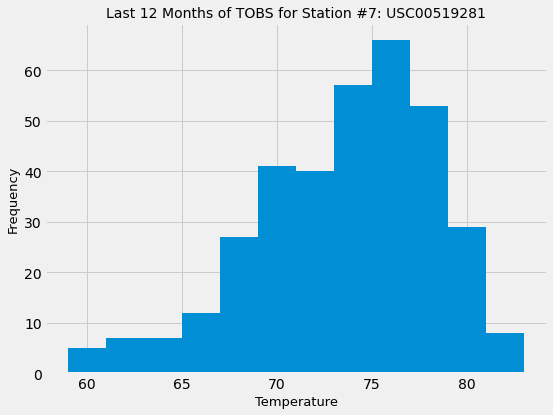

In [20]:
# histogram
plt.figure(figsize=(8,6))
plt.hist(temp, bins=12)
plt.xlabel('Temperature', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title(f'Last 12 Months of TOBS for Station #{most_active_station[0]}: {most_active_station[1]}', fontsize=14)
plt.show()

## Bonus Challenge Assignment

### Temperature Analysis I

In [21]:
# Identify the average temperature in June at all stations across all available years in the dataset. 
# Do the same for December temperature.
temp_df_to_be = session.query(Measurement.date, Measurement.station, Measurement.tobs, Measurement.prcp).all()
temp_df = pd.DataFrame(temp_df_to_be)
temp_df

,date,station,tobs,prcp
0,2010-01-01,USC00519397,65.0,0.08
1,2010-01-02,USC00519397,63.0,0.00
2,2010-01-03,USC00519397,74.0,0.00
3,2010-01-04,USC00519397,76.0,0.00
4,2010-01-06,USC00519397,73.0,NaN
...,...,...,...,...
19545,2017-08-19,USC00516128,71.0,0.09
19546,2017-08-20,USC00516128,78.0,NaN
19547,2017-08-21,USC00516128,76.0,0.56
19548,2017-08-22,USC00516128,76.0,0.50


In [22]:
# Code from tutor: Sandhya Kumari (I didn't know you can just do 'pd.to_datetime' - that's amazing!)
# Add and turn date column into datetime
temp_df.date = pd.to_datetime(temp_df.date, infer_datetime_format=True)

# Set the date to be the index and drop the other date column
temp_df = temp_df.set_index(temp_df['date'])
temp_df = temp_df.drop(columns='date')

# Get data that belongs to June and December
june_df = temp_df[temp_df.index.month == 6]
dec_df = temp_df[temp_df.index.month == 12]

In [23]:
# Get the average of TOBS in June and December
# Get the mean as 'series' as oppsoed to 'float' (temp_df['tobs'].mean)
# Don't really get it: why the above spits out float but below spits out series...
mean_june = june_df.mean()
mean_dec = dec_df.mean()

In [24]:
# Use the t-test to determine whether the difference in the means
import scipy.stats as stats
stats.ttest_ind(mean_june, mean_dec, equal_var=False)

Ttest_indResult(statistic=0.037102211930654896, pvalue=0.9737827130877195)

Unpaired t-test is used because we are comparing the mean of two different groups. June will have a certain range of temperature, while December will have a different range. The mean for the two months are unrelated.

There's no difference in the mean of tobs for June and December.

### Temperature Analysis II

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
### Trip date: 12/05/16 - 12/18/16 ### 
trip = calc_temps('2015-12-05', '2015-12-18')
min_t, avg_t, max_t = trip[0]
min_t, avg_t, max_t

(66.0, 73.13953488372093, 82.0)

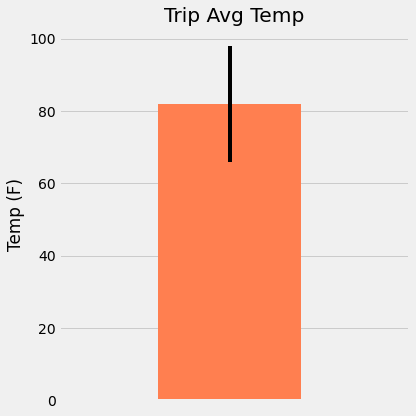

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(6,6))
xpos = 1
y_err = max_t - min_t
plt.bar(xpos, max_t, yerr = y_err, color='coral')
plt.xticks(range(xpos))
plt.xlim(0.05, (xpos)+1)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.tight_layout()
plt.show()

## Daily Rainfall Average

In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

total_rain_trip = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
filter(Measurement.date >= '2015-12-05').filter(Measurement.date <= '2015-12-18').\
filter(Station.station == Measurement.station).\
group_by(Measurement.station).\
order_by(func.sum(Measurement.prcp).desc()).all()

total_rain_trip

[('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  3.1000000000000005),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.9499999999999997),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.58),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  1.2800000000000002),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.7),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.63),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.11)]

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip: 12/05/16 - 12/19/16
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
## code from https://stackoverflow.com/questions/993358/creating-a-range-of-dates-in-python
start_date_trip = dt.date(2016, 12, 5)
numdays = 14
                           
# Use the start and end date to create a range of dates
dateList = []

for day in range(0, numdays):
    dateList.append(start_date_trip + dt.timedelta(days=day))

In [31]:
# Stip off the year and save a list of %m-%d strings
m_d_list = []
# List of datas for pandas plot
trip_date = []

for date in dateList:
    m_d_list.append(date.strftime('%m-%d'))
    trip_date.append(date.strftime('%Y-%m-%d'))

# Loop through the list of %m-%d strings and calculate the normals for each date
for md in m_d_list:
    normals.append(daily_normals(md)[0])

In [32]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
normals_df['trip_date'] = trip_date
normals_df.set_index(['trip_date'], inplace=True)
normals_df

,Min Temp,Avg Temp,Max Temp
trip_date,,,
2016-12-05,64.0,70.921569,78.0
2016-12-06,61.0,69.392157,78.0
2016-12-07,58.0,69.200000,79.0
2016-12-08,60.0,70.274510,83.0
2016-12-09,64.0,71.901961,80.0
2016-12-10,61.0,71.245283,78.0
2016-12-11,64.0,72.387755,78.0
2016-12-12,64.0,70.882353,79.0
2016-12-13,65.0,70.942308,80.0


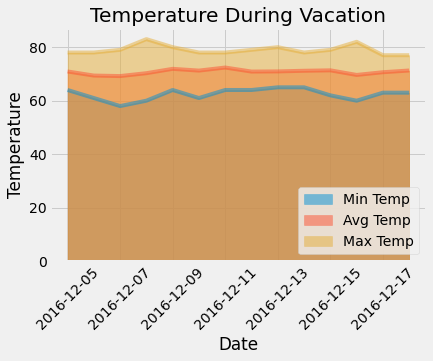

In [33]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', rot=45, stacked=False)
plt.title('Temperature During Vacation')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.legend(loc='lower right')
plt.show()